In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys

%load_ext autoreload
%autoreload 1
%aimport main_exp
import main_exp
%aimport main_ode
import main_ode

import seaborn as sns
# Set seaborn style as default
sns.set(style="whitegrid")
# Adjust font sizes globally
plt.rcParams.update({
    "font.size": 14,  # Base font size
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 14,  # Label font size
    "xtick.labelsize": 12,  # X-axis tick label size
    "ytick.labelsize": 12,  # Y-axis tick label size
    "legend.fontsize": 12  # Legend font size
})

SLURM_CPUS_PER_TASK: 0
OMP_NUM_THREADS: 0
os.cpu_count(): 11
[JAX CONFIG] Using 11 CPU threads


# Effect of T

In [2]:
T_range = [2, 3, 4, 5, 6, 7, 8]
lr = 0.1

r_1 = 1.0
r_2 = 1.0
r_12 = 0.0
tau_1 = 10.0
tau_2 = 10.0


D = 1000
n = 5
epochs = 1000
savepoints = 100

In [3]:
teacher = main_exp.create_teacher(D, main_exp.create_key(main_exp.random_seed()))
students_1 = main_exp.create_student(D, n, main_exp.create_key(main_exp.random_seed()))
students_2 = main_exp.create_student(D, n, main_exp.create_key(main_exp.random_seed()))

<Figure size 640x480 with 0 Axes>

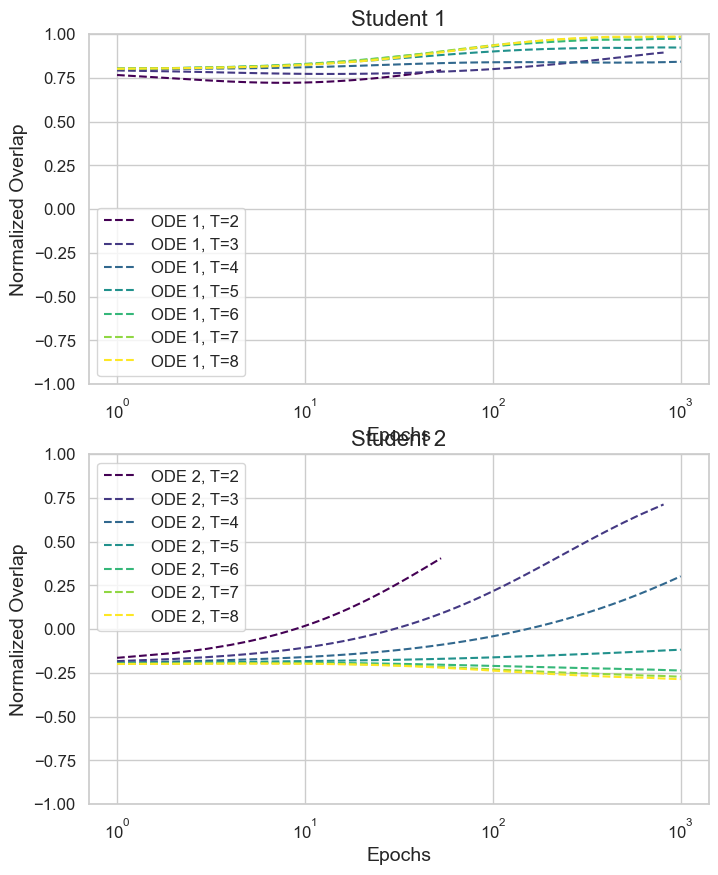

In [4]:
# def perceptron(dim, Covariance):
#     teacher = random.multivariate_normal(mean=np.zeros(Covariance.shape[0]), cov=Covariance)
#     teacher = teacher / np.linalg.norm(teacher) * np.sqrt(dim)
#     return teacher

# def population_covariance(D, delta, index):
#     covariance_matrix = np.zeros((D, D))
#     #index = int(jnp.round((1-rho) * D))
#     covariance_matrix[:index, :index] = np.eye(index)
#     covariance_matrix[index:, index:] = np.eye(D - index) * delta
#     return covariance_matrix


# Covariance_t = population_covariance(D, 0.0, 1)
# Covariance_1 = population_covariance(D, 0.0, 2)

# teacher = perceptron(D, Covariance_t)
# student_1 = perceptron(D, Covariance_1)
# # student_2 = perceptron(D, Covariance_2)
# student_2 = student_1 + np.random.normal(0, 1, D) * 0.001


def sweep_T_and_plot(T_range, D, n, lr, teacher, students_1, students_2, r_1, r_2, r_12, tau_1, tau_2, epochs, savepoints):
    # Get initial order parameters
    J_1, J_2, Q_1, Q_2, Q_12 = main_exp.order_params_ode(students_1, students_2, teacher, D)
    J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init = 0.8, -0.2, 1, 1, 0
    S = np.einsum('D,D->', teacher, teacher) / D

    colors = plt.cm.viridis(np.linspace(0, 1, len(T_range)))
    fig, ax = plt.subplots(2, 1, figsize=(8, 10))

    for idx, T in enumerate(T_range):
        # # Simulation
        # J_1_s, J_2_s, Q_1_s, Q_2_s, Q_12_s = main_exp.Run_simulation(
        #     D, n, lr, teacher, students_1, students_2, T, r_1, r_2, r_12, tau_1, tau_2, epochs, savepoints
        # )
        # ODE
        J_1_s_ode, J_2_s_ode, Q_1_s_ode, Q_2_s_ode, Q_12_s_ode = main_ode.ODE_solver(
            lr, T, r_1, r_2, r_12, tau_1, tau_2, 1/D, epochs, savepoints,
            J_1_init, J_2_init, Q_1_init, Q_2_init, Q_12_init, S
        )
        
        log_epochs = np.unique(np.logspace(0, np.log10(epochs - 1), num=savepoints, dtype=int))
        log_epochs_0 = np.concatenate((np.array([0]), log_epochs))

        # # calculate normalized overlap
        # overlaps_1 = J_1_s / (np.sqrt(Q_1_s * S))
        # mean_overlaps_1 = np.mean(overlaps_1, axis=1)
        # std_overlaps_1 = np.std(overlaps_1, axis=1)

        # overlaps_2 = J_2_s / (np.sqrt(Q_2_s * S))
        # mean_overlaps_2 = np.mean(overlaps_2, axis=1)
        # std_overlaps_2 = np.std(overlaps_2, axis=1)

        overlaps_1_ode = J_1_s_ode / (np.sqrt(Q_1_s_ode * S))
        overlaps_2_ode = J_2_s_ode / (np.sqrt(Q_2_s_ode * S))

        e = len(log_epochs_0)

        # Plot with color gradient for each T
        # ax.fill_between(log_epochs[:e], mean_overlaps_1[1:e] - std_overlaps_1[1:e], mean_overlaps_1[1:e] + std_overlaps_1[1:e], color=colors[idx], alpha=0.2)
        # ax.plot(log_epochs[:e], mean_overlaps_1[1:e], label=f'Student 1, T={T}', color=colors[idx])
        ax[0].plot(log_epochs[:e], overlaps_1_ode[1:e], linestyle='--', color=colors[idx], label=f'ODE 1, T={T}')
        ax[0].set_title('Student 1')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Normalized Overlap')
        ax[0].set_xscale('log')
        ax[0].legend()

        # y axis from -1 to 1
        ax[0].set_ylim([-1, 1])


        ax[1].plot(log_epochs[:e], overlaps_2_ode[1:e], linestyle='--', color=colors[idx], label=f'ODE 2, T={T}')
        ax[1].set_title('Student 2')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Normalized Overlap')
        ax[1].set_xscale('log')
        ax[1].legend()

        # y axis from -1 to 1
        ax[1].set_ylim([-1, 1])

        # ax.fill_between(log_epochs[:e], mean_overlaps_2[1:e] - std_overlaps_2[1:e], mean_overlaps_2[1:e] + std_overlaps_2[1:e], color=colors[idx], alpha=0.1)
        # ax.plot(log_epochs[:e], mean_overlaps_2[1:e], label=f'Student 2, T={T}', color=colors[idx], linestyle=':')
        # ax.plot(log_epochs[:e], overlaps_2_ode[1:e], linestyle='--', color=colors[idx], label=f'ODE 2, T={T}')

# tight layout
plt.tight_layout()
plt.show()
# plt.savefig(f'figures/sweep_T_lr{lr}_r1_{r_1}_r2_{r_2}_r12_{r_12}_tau1_{tau_1}_tau2_{tau_2}_D{D}_n{n}.png', dpi=300)
# plt.close()
sweep_T_and_plot(T_range, D, n, lr, teacher, students_1, students_2, r_1, r_2, r_12, tau_1, tau_2, epochs, savepoints)